In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter
import numpy as np
import os
import shutil
from sklearn.utils import resample
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
dataset_path = "/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group"

In [5]:
BATCH_SIZE = 32

In [6]:
# Step 1: Load dataset
dataset = image_dataset_from_directory(
    dataset_path,
    labels="inferred",
    label_mode="int",
    image_size=(64, 64),  # Resize images to a standard size
    batch_size=BATCH_SIZE,
    shuffle=True
)

Found 6000 files belonging to 8 classes.


In [7]:
# Step 2: Check class distribution
class_names = dataset.class_names
class_counts = Counter()
for _, labels in dataset.unbatch():
    class_counts[int(labels.numpy())] += 1

print("Class Distribution:")
for i, count in class_counts.items():
    print(f"{class_names[i]}: {count}")

Class Distribution:
A-: 1009
AB-: 761
O+: 852
O-: 712
B-: 741
AB+: 708
B+: 652
A+: 565


In [8]:
import matplotlib.pyplot as plt

def plot_class_distribution(class_names, class_counts):
    """
    Plots the distribution of classes in the dataset.

    Parameters:
    - class_names (list): List of class names.
    - class_counts (dict): Dictionary with class indices as keys and counts as values.

    Returns:
    - None
    """
    # Extract class names and their corresponding counts
    classes = [class_names[i] for i in class_counts.keys()]
    counts = [class_counts[i] for i in class_counts.keys()]

    # Plot the bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts, color='skyblue')
    plt.xlabel('Classes', fontsize=14)
    plt.ylabel('Number of Images', fontsize=14)
    plt.title('Dataset Class Distribution', fontsize=16)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Annotate the bar chart with counts
    for i, count in enumerate(counts):
        plt.text(i, count + 5, str(count), ha='center', fontsize=12)

    plt.tight_layout()
    plt.show()


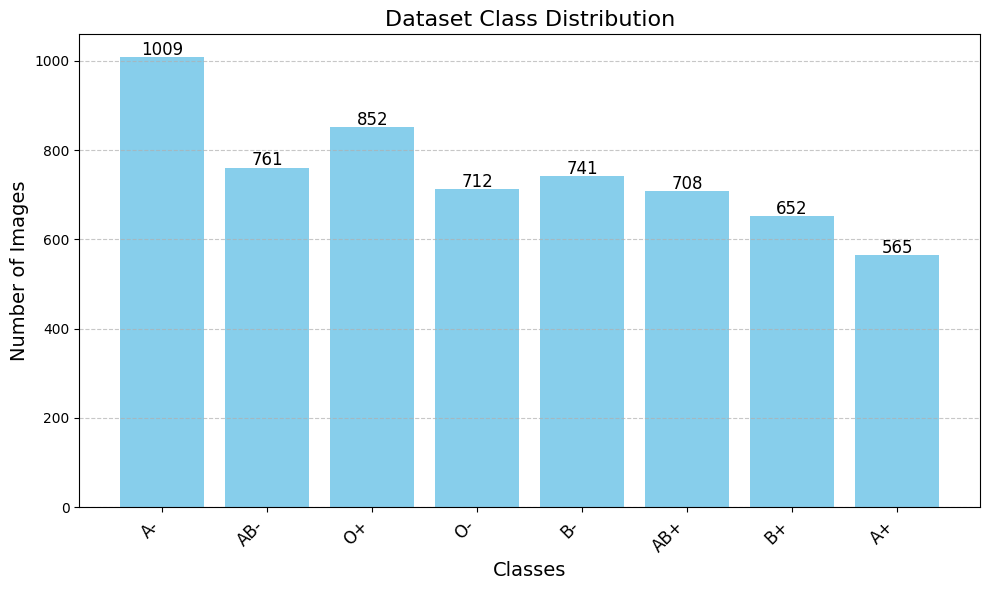

In [9]:
# Assuming class_names and class_counts are already calculated
plot_class_distribution(class_names, class_counts)


In [10]:
max_count = max(class_counts.values())

In [11]:
# Function to oversample a class
def oversample_class(class_id, count, max_count):
    # Ensure the dataset is unbatched for filtering
    unbatched_dataset = dataset.unbatch()
    
    # Filter the dataset for the specific class
    class_dataset = unbatched_dataset.filter(lambda img, lbl: tf.equal(lbl, class_id))
    
    # Calculate the number of repetitions needed
    repeat_factor = max_count // count + (max_count % count > 0)
    
    # Repeat the dataset to match the desired count
    return class_dataset.repeat(repeat_factor).take(max_count)


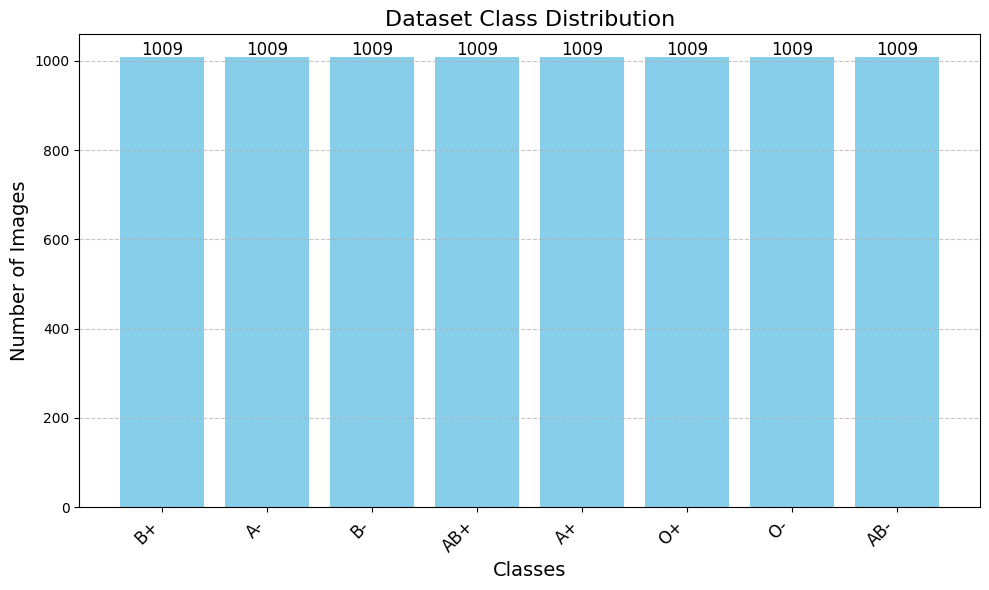

In [12]:
# Step 1: Balance the dataset
balanced_datasets = []
for class_id, count in class_counts.items():
    balanced_datasets.append(oversample_class(class_id, count, max_count))

# Step 2: Combine balanced datasets
balanced_dataset = tf.data.Dataset.sample_from_datasets(balanced_datasets)

# Step 3: Check balanced class distribution
balanced_class_counts = Counter([int(lbl.numpy()) for _, lbl in balanced_dataset])
plot_class_distribution(class_names, balanced_class_counts)

# Step 4: Batch the balanced dataset
balanced_dataset = balanced_dataset.batch(BATCH_SIZE,drop_remainder=True)


In [13]:
for sample in balanced_dataset.take(10):
    print(sample[0].shape)


(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)


In [14]:
balanced_dataset_unbatched = balanced_dataset.unbatch()
dataset_size = sum(1 for _ in balanced_dataset_unbatched)
print(f"Total dataset size: {dataset_size}")


Total dataset size: 8064


In [17]:
# Unbatch the dataset to work at the sample level
balanced_dataset_unbatched = balanced_dataset.unbatch()

# Compute sizes based on dataset size and desired splits
train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)

# Split the dataset into training, validation, and test
train_dataset = balanced_dataset_unbatched.take(train_size)
val_test_dataset = balanced_dataset_unbatched.skip(train_size)
val_dataset = val_test_dataset.take(val_size)
test_dataset = val_test_dataset.skip(val_size)

# Rebatch the datasets after splitting
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

# Check the number of batches in each dataset
train_batch_count = sum(1 for _ in train_dataset)
val_batch_count = sum(1 for _ in val_dataset)
test_batch_count = sum(1 for _ in test_dataset)

print(f"Training dataset size: {train_batch_count * BATCH_SIZE}")
print(f"Validation dataset size: {val_batch_count * BATCH_SIZE}")
print(f"Testing dataset size: {test_batch_count * BATCH_SIZE}")


Training dataset size: 5632
Validation dataset size: 1600
Testing dataset size: 800


In [19]:

def create_high_accuracy_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'), 
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        
        tf.keras.layers.Dense(len(class_names), activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model



# Create the model
high_acc_model = create_high_accuracy_model()




In [20]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Define ReduceLROnPlateau callback to reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',          # Monitor validation loss
    factor=0.5,                  # Reduce the learning rate by a factor of 0.5
    patience=3,                  # Wait for 3 epochs without improvement before reducing LR
    verbose=1,                   # Print a message when the learning rate is reduced
    min_lr=1e-6                  # Minimum learning rate to avoid too small values
)

# Define EarlyStopping callback to stop training when validation loss doesn't improve
early_stop = EarlyStopping(
    monitor='val_loss',          # Monitor validation loss
    patience=5,                  # Stop after 5 epochs without improvement
    verbose=1,                   # Print a message when training is stopped
    restore_best_weights=True    # Restore the model weights from the best epoch
)


In [21]:
# Train the model

history_high_acc = high_acc_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,  # Adjust the number of epochs based on your preference
    callbacks=[reduce_lr, early_stop]
    
)



Epoch 1/50


I0000 00:00:1732952956.976059     106 service.cc:145] XLA service 0x7d372c023c60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732952956.976145     106 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


      4/Unknown 12s 53ms/step - accuracy: 0.0807 - loss: 386.9021

I0000 00:00:1732952966.845525     106 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_10', 4 bytes spill stores, 12 bytes spill loads

I0000 00:00:1732952966.859585     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    175/Unknown 21s 51ms/step - accuracy: 0.1322 - loss: 46.1759

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


176/176 ━━━━━━━━━━━━━━━━━━━━ 33s 121ms/step - accuracy: 0.1322 - loss: 45.7877 - val_accuracy: 0.1369 - val_loss: 2.0743 - learning_rate: 0.0010
Epoch 2/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 22s 123ms/step - accuracy: 0.1985 - loss: 1.9919 - val_accuracy: 0.4344 - val_loss: 1.9004 - learning_rate: 0.0010
Epoch 3/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 21s 119ms/step - accuracy: 0.4280 - loss: 1.5410 - val_accuracy: 0.5269 - val_loss: 1.5984 - learning_rate: 0.0010
Epoch 4/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 20s 115ms/step - accuracy: 0.5919 - loss: 1.1231 - val_accuracy: 0.5294 - val_loss: 1.4023 - learning_rate: 0.0010
Epoch 5/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 20s 112ms/step - accuracy: 0.6519 - loss: 0.9916 - val_accuracy: 0.6413 - val_loss: 1.3445 - learning_rate: 0.0010
Epoch 6/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 21s 119ms/step - accuracy: 0.6784 - loss: 0.8611 - val_accuracy: 0.6456 - val_loss: 1.1234 - learning_rate: 0.0010
Epoch 7/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 22s 122ms/step - accuracy: 0.7012 - loss

In [22]:
# Evaluate the model on validation data
high_acc_eval = high_acc_model.evaluate(val_dataset)
print(f"High Accuracy Model - Loss: {high_acc_eval[0]}, Accuracy: {high_acc_eval[1]}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.9424 - loss: 0.3160
High Accuracy Model - Loss: 0.3256220519542694, Accuracy: 0.9387500286102295


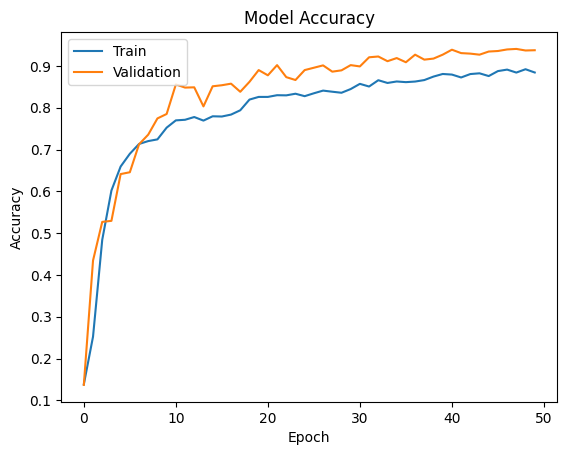

In [23]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Call the function to display the accuracy graph
plot_accuracy(history_high_acc)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Classification Report:
              precision   

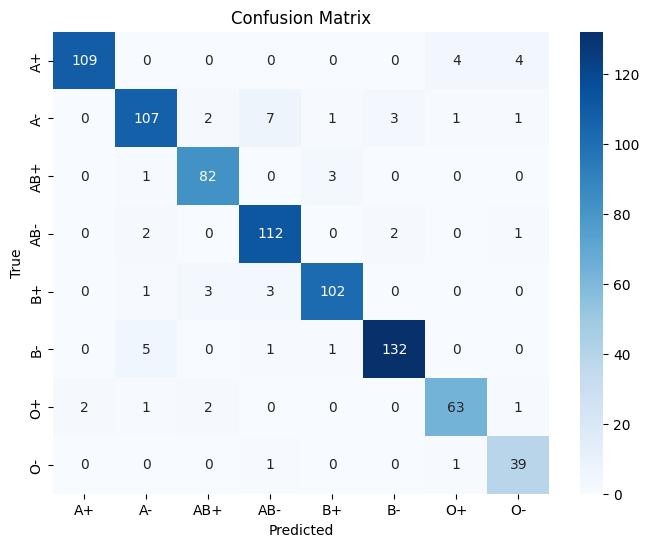

In [24]:
# Get predictions on the test dataset
y_true = []  # True labels
y_pred = []  # Predicted labels

# Iterate over the test dataset and collect the true and predicted labels
for images, labels in test_dataset:
    predictions = high_acc_model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)  # Convert one-hot encoded predictions to class labels
    y_true.extend(labels.numpy())  # Convert tensor to numpy array and append
    y_pred.extend(predicted_labels)  # Append the predicted labels

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:")
print(report)

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [25]:
high_acc_model.save('model.h5')  # The model will be saved as 'my_model.h5'
print("Model saved as HDF5 format.")

Model saved as HDF5 format.


In [ ]:
pip show pillow